John Searight

The below notebook is a custom solution to a network diffusion problem. I developed a custom model that was compatible with NDLib python library.

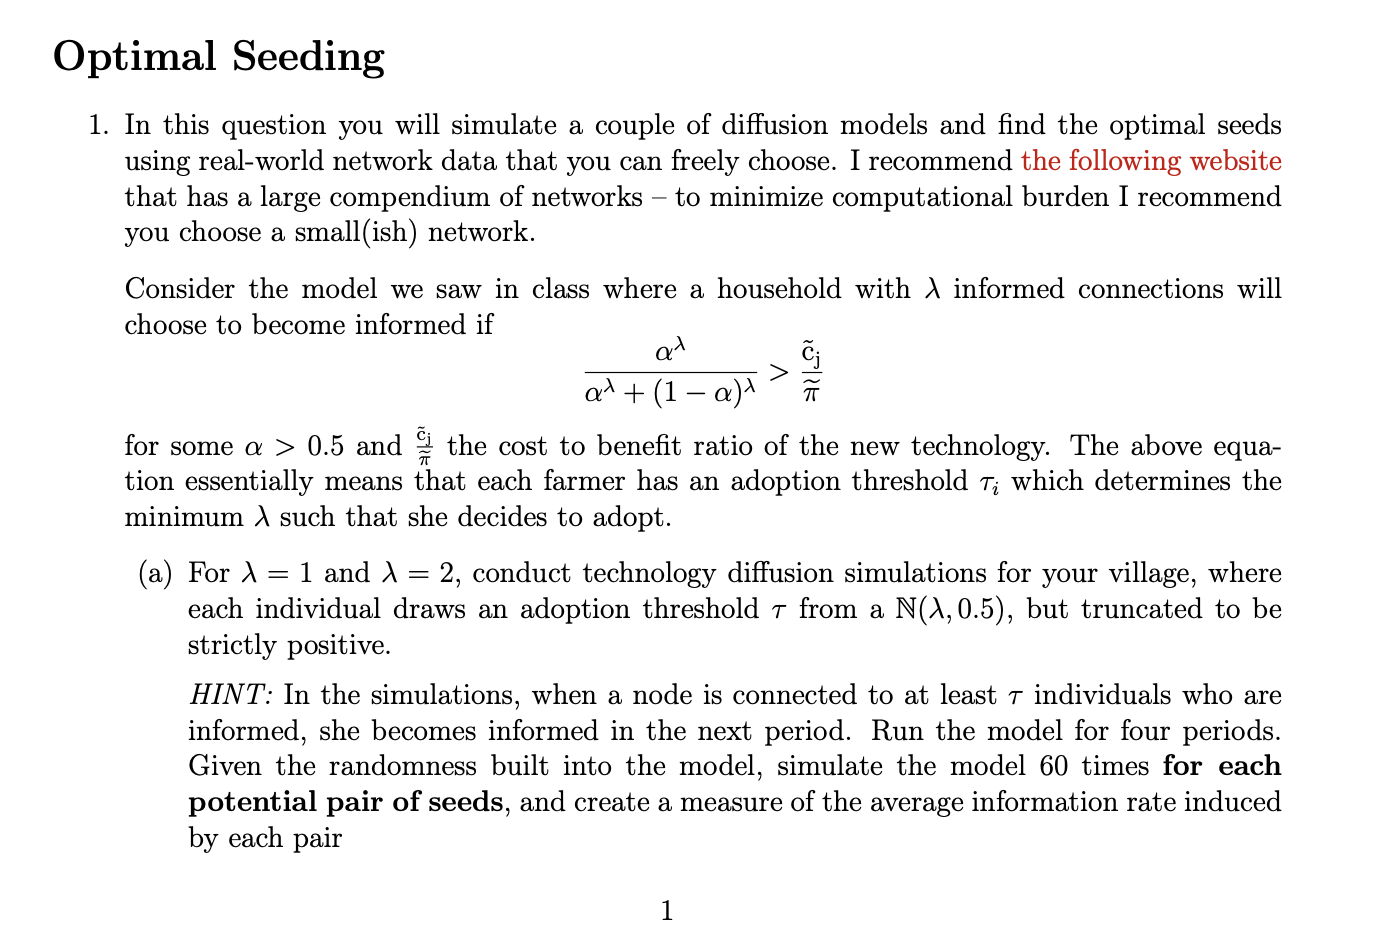

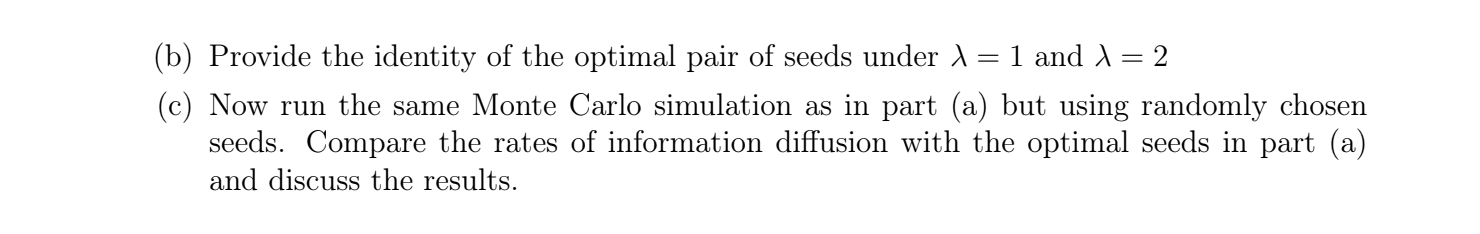

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ndlib
import math
import networkx as nx
import random 
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from networkx import random_layout, circular_layout
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
#Import network diffusion python library
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.utils import multi_runs
from ndlib.models.epidemics import ThresholdModel

# Tortoise Data Set

We used a data set regarding a network of tortoises.

Nodes	88
Edges	184

https://networkrepository.com/reptilia-tortoise-network-bsv-1998.php


#### Import edge list and visualize

In [ ]:
g = nx.read_edgelist('/content/drive/MyDrive/Networks/reptilia-tortoise-network-bsv-1998.zip (Unzipped Files)/reptilia-tortoise-network-bsv-1998.edges')

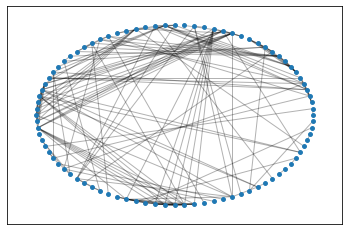

In [ ]:
pos = circular_layout(g)
import matplotlib.pyplot as plt
%matplotlib inline
cmap = cm.get_cmap('rainbow')
nx.draw_networkx_nodes(g, pos, node_size=15, cmap=cmap)
nx.draw_networkx_edges(g, pos, alpha=0.3)
plt.show()

with_labels = True

In [ ]:
#remove any isolated nodes
g.remove_nodes_from(nx.isolates(g))

#### Generate Seed Pairs

In [ ]:
#Generate list of all possible seed pairs
import itertools
seed_list = itertools.permutations(g.nodes, 2)
seeds = list(seed_list)
len(seeds)

7656

### λ = 1 

Corresponds to simple diffusion (node with one 'informed' connection). In this scenario the cost to benefit ratio of the new technology will have to be less than α in order to adopt.

In [ ]:
#Specify model
config = mc.Configuration()
model = ep.ThresholdModel(g)

#### Create Thresholds

In order to adapt to the ndlib threshold model, I need to transform my thresholds into probabilities from 0-1. I will get the total number of nodes for each neighbor and a normally generated threshold based on the instructions. Then I will divide that threshold by the number of neighbors to get a probability of adoption (greater or lower than .5). Those greater than 1 will be labeled as 1.

In [ ]:
#Loop to add random thresholds from the normal distribution specified. Create truncated with while loop
threshold_list = []
for i in g.nodes():
    threshold = np.random.normal(1,.5)
    #ensure threshold is above 0 using while loop
    while threshold < 0:
      threshold = np.random.normal(1,.5)
    config.add_node_configuration("threshold", i, threshold)
    #double check all positive
    threshold_list.append(threshold)

    #double check all thresholds are above 0
    threshold_list

number_neighbors = []
node = []
for i in g.nodes():
  y = len(list(g.neighbors(i)))
  number_neighbors.append(y)
  node.append(i)


node_nbrs = dict(list(zip(node,number_neighbors)))
nbrs_df = pd.DataFrame.from_dict(node_nbrs, orient='index', columns=['# Neighbors'])
#Add thresholds
nbrs_df['Nbrs_Threshold'] = threshold_list
nbrs_df['Threshold_Prob'] = nbrs_df['Nbrs_Threshold'] / nbrs_df['# Neighbors']
nbrs_df['Threshold_Prob'].values[nbrs_df['Threshold_Prob'].values > 1] = 1
nbrs_df

,# Neighbors,Nbrs_Threshold,Threshold_Prob
116,1,0.968087,0.968087
117,2,0.786688,0.393344
13,4,0.841676,0.210419
111,5,0.335316,0.067063
72,5,1.829852,0.365970
...,...,...,...
34,1,0.466880,0.466880
68,1,1.014189,1.000000
133,1,0.877314,0.877314
106,1,1.694089,1.000000


In [ ]:
#Turn this into a list of nodes and thresholds for use in diffusion suimulation
node_thresh = list(zip(g.nodes,nbrs_df['Threshold_Prob']))

#### Run Simulation

Here I used Python [ndlib libray](https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/Threshold.html) to create a loop that will apply the thresholds and run a simulation to identify the optimal pair of nodes.

To run this 60 times with 4 iterations for each seed pair is computationally burdensome for a network of this size, so I ran less repetitions, but the counter can easily be adjusted to increase the number of runs.

In [ ]:
import pandas as pd
seed_used = []
avg_rate = []
adopted_seeds = 2

for i in seeds:
  counter = 0
  #Counter can be adjusted to 60 if I want to run 60 simulations for each pair
  while counter < 5:
    seed_used.append(i)
    #Instantiate model and configuration
    model = ep.ThresholdModel(g)
    config = mc.Configuration()
    #Add 'infected' initial seeds
    config.add_model_initial_configuration("Infected", i)
    #For loop iterating across nodes to add thresholds
    for j, f in node_thresh:
        config.add_node_configuration("threshold", j, f)
    #Set the configuration
    model.set_initial_status(config)
    #Run four iterations
    iterations = model.iteration_bunch(4)
    #Extract insights
    df = pd.DataFrame.from_dict(iterations, orient='columns')
    info_rates = []
    for k in df['node_count']:
        step_rate = (k[1] / len(g.nodes) - (adopted_seeds/len(g.nodes))) #converted nodes/total nodes - original converted nodes
        info_rates.append(step_rate)
    max_rate = info_rates[3]
    avg_rate.append(max_rate)
    #Reset model
    model.reset
    counter = counter + 1

#Turn back into DF and analyze output
seed_rates = dict(list(zip(seed_used, avg_rate)))
analysis = pd.DataFrame.from_dict(seed_rates, orient='index', columns=['Avg_Information_Rate'])
analysis.sort_values(by='Avg_Information_Rate', ascending=False)

,Avg_Information_Rate
"(11, 61)",0.647727
"(61, 11)",0.647727
"(11, 63)",0.636364
"(63, 11)",0.636364
"(63, 38)",0.625000
...,...
"(7, 60)",0.000000
"(64, 60)",0.000000
"(64, 7)",0.000000
"(34, 115)",0.000000


Above, the top seeds from the model after a few runs are displayed (duplicates can be ignored). The highest information rate is 

### λ = 2

Same as above but adjust the normal distribution to make lambda 2 instead of 1. Again, the counter can be adjusted to increase the amount of runs to 60

In [ ]:
#Loop to add random thresholds from the normal distribution specified. Create truncated with while loop
threshold_list = []
for i in g.nodes():
    ## ADJUST DISTRIBUTION HERE
    threshold = np.random.normal(2,.5)
    #ensure threshold is above 0 using while loop
    while threshold < 0:
      threshold = np.random.normal(2,.5)
    config.add_node_configuration("threshold", i, threshold)
    #double check all positive
    threshold_list.append(threshold)

    #double check all thresholds are above 0
    threshold_list

number_neighbors = []
node = []
for i in g.nodes():
  y = len(list(g.neighbors(i)))
  number_neighbors.append(y)
  node.append(i)


node_nbrs = dict(list(zip(node,number_neighbors)))
nbrs_df = pd.DataFrame.from_dict(node_nbrs, orient='index', columns=['# Neighbors'])
#Add thresholds
nbrs_df['Nbrs_Threshold'] = threshold_list
nbrs_df['Threshold_Prob'] = nbrs_df['Nbrs_Threshold'] / nbrs_df['# Neighbors']
nbrs_df
node_thresh = list(zip(g.nodes,nbrs_df['Threshold_Prob']))

import pandas as pd
seed_used = []
avg_rate = []

for i in seeds:
  counter = 0
  #Counter can be adjusted to 60 if I want to run 60 simulations for each pair
  while counter < 5:
    seed_used.append(i)
    #Instantiate model and configuration
    model = ep.ThresholdModel(g)
    config = mc.Configuration()
    #Add 'infected' initial seeds
    config.add_model_initial_configuration("Infected", i)
    #For loop iterating across nodes to add thresholds
    for j, f in node_thresh:
        config.add_node_configuration("threshold", j, f)
    #Set the configuration
    model.set_initial_status(config)
    #Run four iterations
    iterations = model.iteration_bunch(4)
    #Extract insights
    df = pd.DataFrame.from_dict(iterations, orient='columns')
    info_rates = []
    for k in df['node_count']:
        step_rate = (k[1] / len(g.nodes) - (adopted_seeds/len(g.nodes))) #converted nodes/total nodes - original converted nodes
        info_rates.append(step_rate)
    max_rate = info_rates[3]
    avg_rate.append(max_rate)
    #Reset model
    model.reset
    counter = counter + 1

#Turn back into DF and analyze output
seed_rates = dict(list(zip(seed_used, avg_rate)))
analysis = pd.DataFrame.from_dict(seed_rates, orient='index', columns=['Avg_Information_Rate'])
analysis.sort_values(by='Avg_Information_Rate', ascending=False)

,Avg_Information_Rate
"(114, 8)",0.215909
"(8, 38)",0.215909
"(19, 8)",0.215909
"(8, 114)",0.215909
"(8, 93)",0.215909
...,...
"(69, 54)",0.000000
"(69, 110)",0.000000
"(69, 102)",0.000000
"(69, 28)",0.000000


As you can see above, the average information rate decreases significantly for the top pairs.

### Random Seed Pairs

Now I will use a random pair of seeds to see how diffusion progressed. I will use 100 randomly drawn seeds here and can run it 60 times given the smaller number of seed pairs.

In [ ]:
rand_seeds = (random.sample(seeds, 100))

In [ ]:
#Loop to add random thresholds from the normal distribution specified. Create truncated with while loop
threshold_list = []
for i in g.nodes():
    threshold = np.random.normal(2,.5)
    #ensure threshold is above 0 using while loop
    while threshold < 0:
      threshold = np.random.normal(2,.5)
    config.add_node_configuration("threshold", i, threshold)
    #double check all positive
    threshold_list.append(threshold)

    #double check all thresholds are above 0
    threshold_list

number_neighbors = []
node = []
for i in g.nodes():
  y = len(list(g.neighbors(i)))
  number_neighbors.append(y)
  node.append(i)


node_nbrs = dict(list(zip(node,number_neighbors)))
nbrs_df = pd.DataFrame.from_dict(node_nbrs, orient='index', columns=['# Neighbors'])
#Add thresholds
nbrs_df['Nbrs_Threshold'] = threshold_list
nbrs_df['Threshold_Prob'] = nbrs_df['Nbrs_Threshold'] / nbrs_df['# Neighbors']
nbrs_df
node_thresh = list(zip(g.nodes,nbrs_df['Threshold_Prob']))

import pandas as pd
seed_used = []
avg_rate = []

for i in rand_seeds:
  counter = 0
  #Counter can be adjusted to 60 if I want to run 60 simulations for each pair
  while counter < 60:
    seed_used.append(i)
    #Instantiate model and configuration
    model = ep.ThresholdModel(g)
    config = mc.Configuration()
    #Add 'infected' initial seeds
    config.add_model_initial_configuration("Infected", i)
    #For loop iterating across nodes to add thresholds
    for j, f in node_thresh:
        config.add_node_configuration("threshold", j, f)
    #Set the configuration
    model.set_initial_status(config)
    #Run four iterations
    iterations = model.iteration_bunch(4)
    #Extract insights
    df = pd.DataFrame.from_dict(iterations, orient='columns')
    info_rates = []
    for k in df['node_count']:
        step_rate = (k[1] / len(g.nodes) - (adopted_seeds/len(g.nodes))) #converted nodes/total nodes - original converted nodes
        info_rates.append(step_rate)
    max_rate = info_rates[3]
    avg_rate.append(max_rate)
    #Reset model
    model.reset
    counter = counter + 1

#Turn back into DF and analyze output
seed_rates = dict(list(zip(seed_used, avg_rate)))
analysis = pd.DataFrame.from_dict(seed_rates, orient='index', columns=['Avg_Information_Rate'])
analysis.sort_values(by='Avg_Information_Rate', ascending=False)

,Avg_Information_Rate
"(35, 19)",0.136364
"(79, 8)",0.125000
"(97, 113)",0.125000
"(37, 69)",0.113636
"(126, 79)",0.102273
...,...
"(29, 128)",0.000000
"(125, 8)",0.000000
"(69, 13)",0.000000
"(44, 61)",0.000000


After a random draw of 100 seeds, we can see that the average information rate decreased even further, indicating that finding the optimal seed pair is significantly better than most randomly drawn seeds, but for one pair that did nearly as well as when lambda = 2.

##### Function for later use

Recognize the above could be more neatly coded within functions, I have created a function for further use.

In [ ]:
def threshold_sim(g, node_thresh, number_adopted_seeds, number_repeats, number_steps):
  seed_used = []
  avg_rate = []
  adopted_seeds = number_adopted_seeds
  for i in seeds:
    counter = 0
    while counter < number_repeats:
      seed_used.append(i)
      model = ep.ThresholdModel(g)
      config = mc.Configuration()
      config.add_model_initial_configuration("Infected", i)
      for j, h in node_thresh:
          config.add_node_configuration("threshold", j, h)
      model.set_initial_status(config)
      iterations = model.iteration_bunch(number_steps)
      df = pd.DataFrame.from_dict(iterations, orient='columns')
      info_rates = []
      for k in df['node_count']:
          step_rate = (k[1] / len(g.nodes) - (adopted_seeds/len(g.nodes))) #converted nodes/total nodes - original converted nodes
          info_rates.append(step_rate)
      max_rate = info_rates[3]
      avg_rate.append(max_rate)
      model.reset
      counter = counter + 1

  seed_rates = dict(list(zip(seed_used, avg_rate)))
  analysis = pd.DataFrame.from_dict(seed_rates, orient='index', columns=['Avg_Information_Rate'])
  analysis = analysis.sort_values(by='Avg_Information_Rate', ascending=False)
  return analysis 